In [1]:
from utils import read_graph_from_json, update_attributes, get_k_L_U
states = ['TN']
district_types = ['SH']
level = 'block'

****************************************
Starting TN SH
****************************************

Starting TN with k = 99 and deviation = 0.1
Thus, we have L = 66317 and U = 73296
Updated to L = 66445 and U = 73358.
Successfully processed plan with 57 whole counties.
Set parameter Username
Academic license - for non-commercial use only - expires 2026-09-26
Dropped 1 and reduced from {'47103', '47051', '47031', '47117', '47003', '47127'} to ['47103', '47051', '47031', '47117', '47003'].
Adding non-dominated, minimal constraints:
['47125']
['47187']
['47141']
['47157']
['47155']
['47119']
['47011']
['47179']
['47113']
['47103', '47051', '47031', '47117', '47003']
['47001']
['47189']
['47165']
['47163']
['47009']
['47073', '47057', '47063', '47059', '47029', '47089']
Time to generate initial inequalities: 9.21 seconds.
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, i

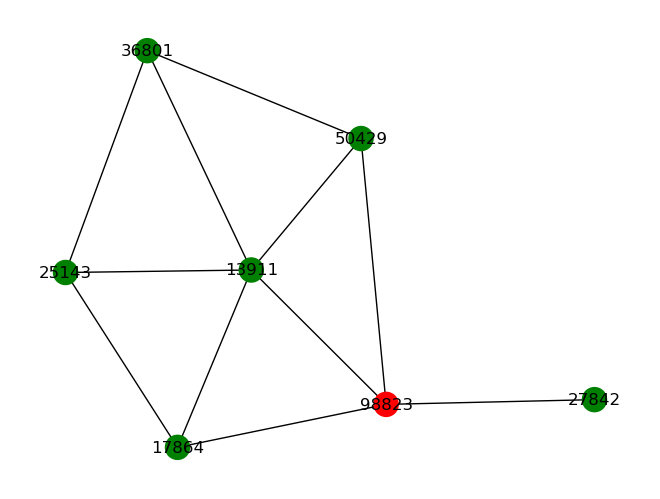

Seeking 6 districts for cluster #25/27 over n = 13266 vertices.
This cluster has counties {'47155', '47009', '47105', '47139', '47089', '47123'} of which {'47105', '47139', '47089', '47123'} are whole.
Compare [L,U] = [66445, 73358] to p(cluster)/size = 67837.17.
First, trying to draw districts at tract-level where n = 102.
Trying tract-level instance with n = 62.
Trying tract-level instance with n = 52.
Trying DAG model, with root geoids = ['47009011202', '47009011302', '47155', '47123', '47089', '47105']
Seeking 1 districts for cluster #26/27 over n = 3616 vertices.
This cluster has counties {'47103', '47127', '47055'} of which {'47103', '47127', '47055'} are whole.
Compare [L,U] = [66445, 73358] to p(cluster)/size = 72126.0.
Seeking 1 districts for cluster #27/27 over n = 4353 vertices.
This cluster has counties {'47023', '47109', '47071'} of which {'47023', '47109', '47071'} are whole.
Compare [L,U] = [66445, 73358] to p(cluster)/size = 70038.0.
Set parameter OutputFlag to value 1


In [2]:
from main import solve_max_whole
from utils import import_from_baf, export_to_baf

results = dict()
filepath = 'C:\\districting-data-2020-conn\\'
filepath2 = 'case-study-plans\\'

for district_type in district_types:
    for state in states:
        print(f"{'*'*40}\nStarting {state} {district_type}\n{'*'*40}\n")    
        filename = state + '_' + level + '.json'
        G = read_graph_from_json( filepath + filename )
        update_attributes(G, state)
        (k, L, U) = get_k_L_U(G, state, district_type)
        if k <= 1:
            print("Skipping because k <= 1.")
            continue
    
        # get warm start plan (statewide)
        filename = 'TN 2022 State House.baf'
        statewide_plan = import_from_baf(G, filepath2, filename)

        # redefine L and U to match the enacted plan
        populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in statewide_plan ]
        L = min( populations )
        U = max( populations )
        print(f"Updated to L = {L} and U = {U}.")

        # extract "urban" districts from these counties:
        #   Davidson (47037), Shelby (47157), Hamilton (47065), Knox (47093), Rutherford (47149)
        # AND, create incumbent plan for rural:=non-urban counties:
        urban_fips = [ '47037', '47157', '47065', '47093', '47149' ]
        urban_districts = list()
        rural_districts = list()
        for district in statewide_plan:
            v = district[0]
            if G.nodes[v]['GEOID20'][0:5] in urban_fips:
                urban_districts.append( district )
            else:
                rural_districts.append( district )

        # solve max whole
        vertices = [ v for district in rural_districts for v in district ]
        results[state, district_type] = solve_max_whole(G.subgraph(vertices), L, U, k-len(urban_districts), rural_districts, verbose=False)

        # export incumbent plan
        plan = results[state, district_type]['incumbent_plan']
        plan += urban_districts
        ga = { G.nodes[i]['GEOID20'] : j for j in range(len(plan)) for i in plan[j] }
        gap = results[state, district_type]['UB'] - results[state, district_type]['LB']
        if gap == 0:
            fn = "case_study.baf"
        else:
            fn = "case_study" + '_' + str(gap) + '.baf'
        export_to_baf(G, geoid_assignment=ga, outfilename=fn)
        
        # export partial plans?
        if gap > 0:
            counter = 0
            for plan in results[state, district_type]['incomplete_plans']:
                counter += 1
                ga = { G.nodes[i]['GEOID20'] : j for j in range(len(plan)) for i in plan[j] }
                fn = "case_study_incomplete_plan_" + str(counter) + ".baf"
                export_to_baf(G, geoid_assignment=ga, outfilename=fn)
    